In [ ]:
# %%

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import random
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA , TruncatedSVD
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

random.seed(42)
#####################################################################

In [ ]:
# %%

# ### Function for Transition Plot (Before-and-After Reduction) ###
# This function creates "Before and After" transition plots for better visualization of dimensionality reduction.
def plot_before_after(original_data, reduced_data, title, sample_size=100):
    # Randomly sample a subset of the data points to avoid clutter
    sample_indices = np.random.choice(len(original_data), size=sample_size, replace=False)
    original_sample = original_data[sample_indices]
    reduced_sample = reduced_data[sample_indices]

    plt.figure(figsize=(10, 6))

    # Plot the original high-dimensional data (projected to 2D with PCA)
    plt.scatter(original_sample[:, 0], original_sample[:, 1], alpha=0.5, label="Original High-Dimensional Data", color='blue')

    # Plot the reduced 2D data
    plt.scatter(reduced_sample[:, 0], reduced_sample[:, 1], alpha=0.7, label="Reduced 2D Data", color='red')

    # Draw arrows from the original point to the reduced point
    for i in range(len(original_sample)):
        plt.arrow(original_sample[i, 0], original_sample[i, 1], 
                  reduced_sample[i, 0] - original_sample[i, 0], 
                  reduced_sample[i, 1] - original_sample[i, 1], 
                  alpha=0.4, color='grey', head_width=0.3, head_length=0.5, lw=0.5)
    
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

def plot_neighbors_before_after(original_data, reduced_data, title, sample_size=100, n_neighbors=5):
    """
    This function visualizes the changes in the neighborhood structure before and after dimensionality reduction.
    For t-SNE and UMAP, local structure and neighbor relationships are more important than global linear structure.

    Parameters:
    - original_data: High-dimensional data
    - reduced_data: 2D data from t-SNE or UMAP
    - title: Title for the plot
    - sample_size: Number of points to sample from the dataset
    - n_neighbors: Number of neighbors to display for each point
    """
    from sklearn.neighbors import NearestNeighbors
    
    # Randomly sample a subset of the data points
    sample_indices = np.random.choice(len(original_data), size=sample_size, replace=False)
    original_sample = original_data[sample_indices]
    reduced_sample = reduced_data[sample_indices]

    # Find nearest neighbors in the original high-dimensional data
    nn_original = NearestNeighbors(n_neighbors=n_neighbors).fit(original_sample)
    distances_orig, indices_orig = nn_original.kneighbors(original_sample)

    # Plot the original data's neighborhood relationships
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(original_sample[:, 0], original_sample[:, 1], alpha=0.5, label="Original High-Dimensional Data", color='blue')

    for i in range(sample_size):
        for neighbor in indices_orig[i]:
            plt.plot([original_sample[i, 0], original_sample[neighbor, 0]], [original_sample[i, 1], original_sample[neighbor, 1]], 
                     'grey', alpha=0.2)
    plt.title(f"{title}: Original High-Dimensional Neighbors")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    # Find nearest neighbors in the reduced low-dimensional data
    nn_reduced = NearestNeighbors(n_neighbors=n_neighbors).fit(reduced_sample)
    distances_red, indices_red = nn_reduced.kneighbors(reduced_sample)

    # Plot the reduced data's neighborhood relationships
    plt.subplot(1, 2, 2)
    plt.scatter(reduced_sample[:, 0], reduced_sample[:, 1], alpha=0.7, label="Reduced Data", color='red')

    for i in range(sample_size):
        for neighbor in indices_red[i]:
            plt.plot([reduced_sample[i, 0], reduced_sample[neighbor, 0]], [reduced_sample[i, 1], reduced_sample[neighbor, 1]], 
                     'grey', alpha=0.2)
    plt.title(f"{title}: Reduced Low-Dimensional Neighbors")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    plt.tight_layout()
    plt.show()
#####################################################################

In [ ]:
# %% 

# ### Loading Dataset ###
# Load the dataset and preprocess date columns to only keep the date part (remove time).
df_path = "F:\\לימודים\\תואר שני\\סמסטר ב\\Data Science 2\\DS2-Final Project\\data-science2-lab-final-project\\src\\team_9\\assets\\erBeforeHospitalization.csv"
er_before_hospitalization2 = pd.read_csv(df_path)

In [ ]:
# %%

# Preprocessing
er_before_hospitalization2['Admission_Entry_Date'] = pd.to_datetime(er_before_hospitalization2['Admission_Entry_Date']).dt.date
er_before_hospitalization2['Release_Date'] = pd.to_datetime(er_before_hospitalization2['Release_Date']).dt.date
er_before_hospitalization2['Admission_Entry_Date2'] = pd.to_datetime(er_before_hospitalization2['Admission_Entry_Date2']).dt.date
er_before_hospitalization2['Release_Date2'] = pd.to_datetime(er_before_hospitalization2['Release_Date2']).dt.date

In [ ]:
# %%

# Handle missing values
er_before_hospitalization2_cleaned = er_before_hospitalization2.dropna()

In [ ]:
# %% 

# ### Ordinal Encoding of Categorical Variables ###
# Identify non-numeric columns (categorical variables) and apply Ordinal Encoding to transform them into numerical form.
non_numeric_columns = er_before_hospitalization2_cleaned.select_dtypes(include=['object']).columns

# Apply Ordinal Encoding for all non-numeric columns
ordinal_encoder = OrdinalEncoder()

# Fit and transform the non-numeric columns using OrdinalEncoder
er_before_hospitalization2_cleaned[non_numeric_columns] = ordinal_encoder.fit_transform(er_before_hospitalization2_cleaned[non_numeric_columns])

In [ ]:
# %%

# Extract numeric columns, including the encoded ones
numeric_columns = er_before_hospitalization2_cleaned.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
# %%

# ### Standardizing the Data ###
# Standardize numeric columns to make sure each feature contributes equally to the dimensionality reduction process.
scaler = StandardScaler()
er_before_hospitalization2_scaled = pd.DataFrame(scaler.fit_transform(er_before_hospitalization2_cleaned[numeric_columns]), columns=numeric_columns)

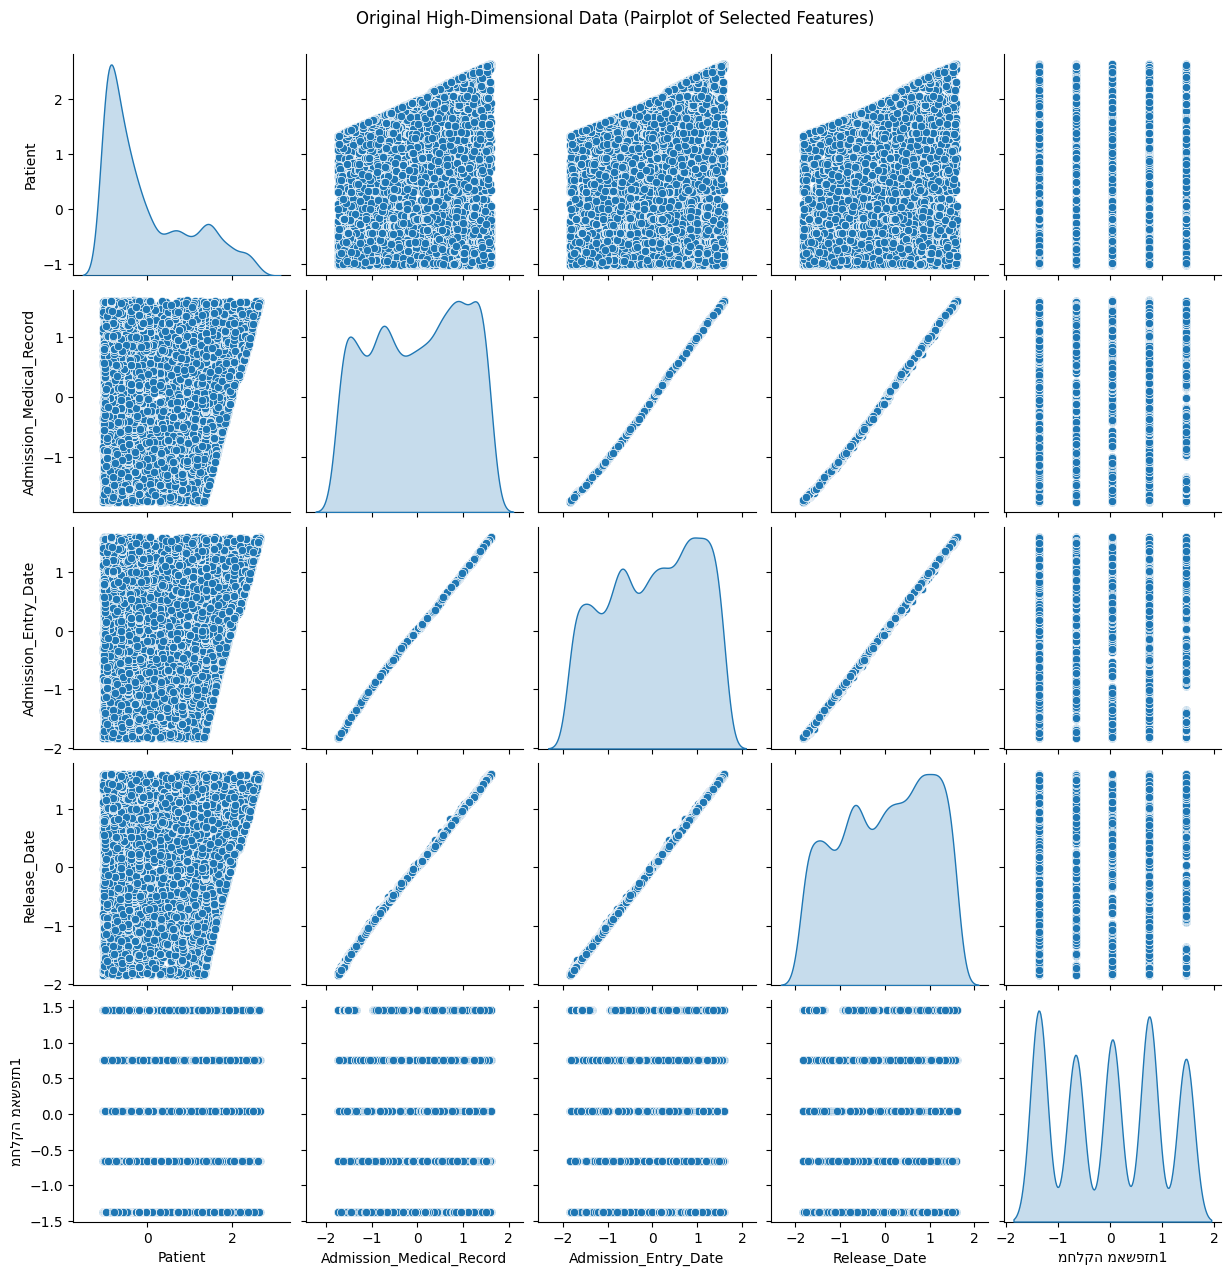

In [ ]:
# %%

# ### Plotting Original Data ###
# This pairplot visualizes the original high-dimensional data using a subset of the first few numeric features.
sns.pairplot(er_before_hospitalization2_scaled[numeric_columns[:5]], diag_kind="kde")
plt.suptitle("Original High-Dimensional Data (Pairplot of Selected Features)", y=1.02)
plt.show()

In [ ]:
# %%

# ### PCA Analysis ###
# PCA is a linear dimensionality reduction method. It reduces the data based on variance, aiming to preserve global structures and linear relationships.
# Apply PCA to the data
pca = PCA(n_components=2)
er_pca = pca.fit_transform(er_before_hospitalization2_scaled)

In [ ]:
# %%

# Explained Variance: Higher variance means better information retention.
explained_variance = pca.explained_variance_ratio_.sum()
# Display the explained variance as HTML
display(HTML(f"<h3>Explained Variance by PCA: {explained_variance * 100:.2f}%</h3>"))

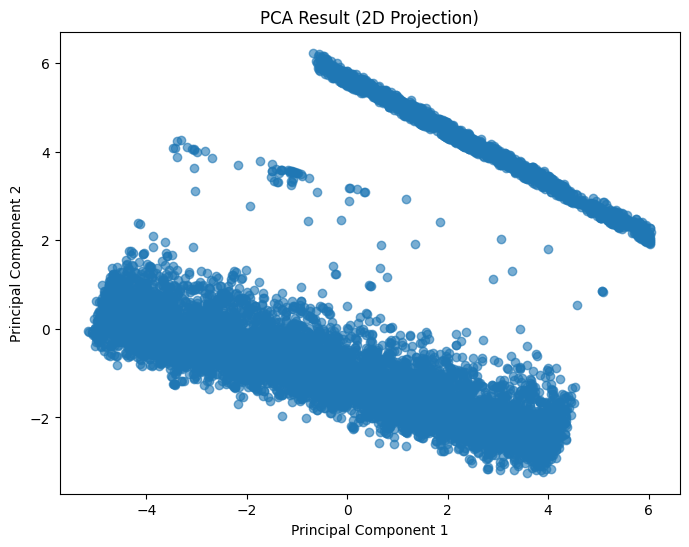

In [ ]:
# %%

# Plot PCA Results
plt.figure(figsize=(8,6))
plt.scatter(er_pca[:, 0], er_pca[:, 1], alpha=0.6)
plt.title('PCA Result (2D Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

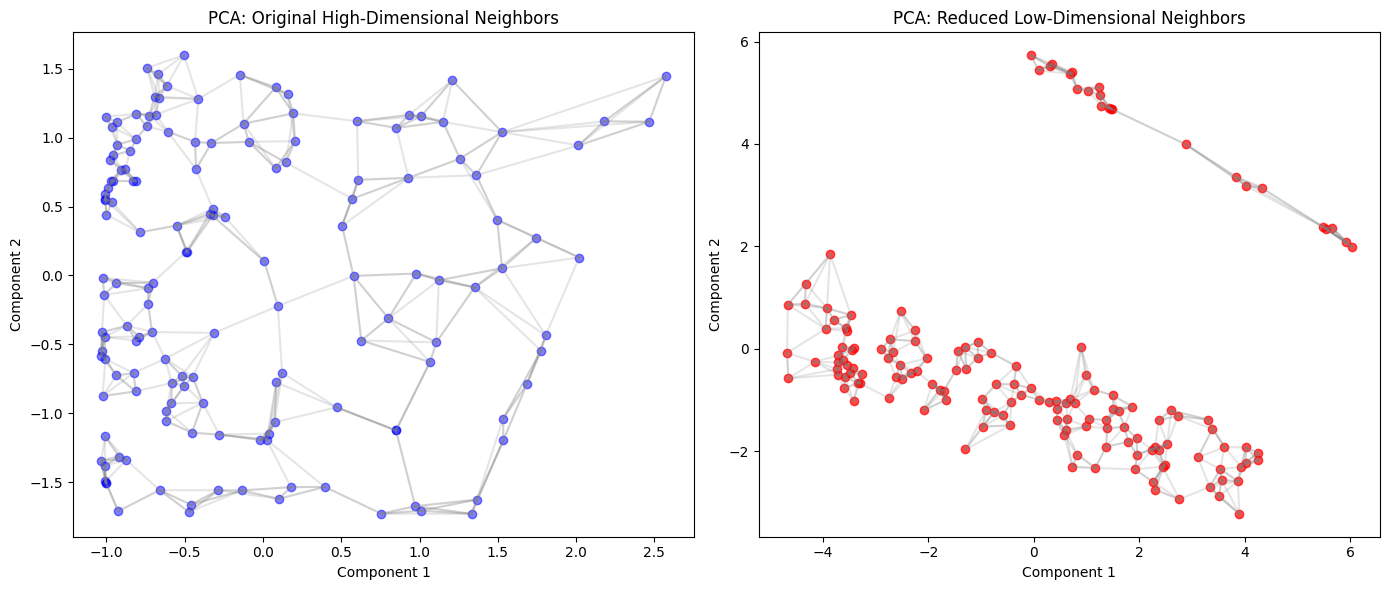

In [ ]:
# %% 

# Apply PCA
pca = PCA(n_components=2)
er_pca = pca.fit_transform(er_before_hospitalization2_scaled)
# Visualize neighborhood relationships for PCA
plot_neighbors_before_after(er_before_hospitalization2_scaled.values[:, :2], er_pca, "PCA", sample_size=150, n_neighbors=5)

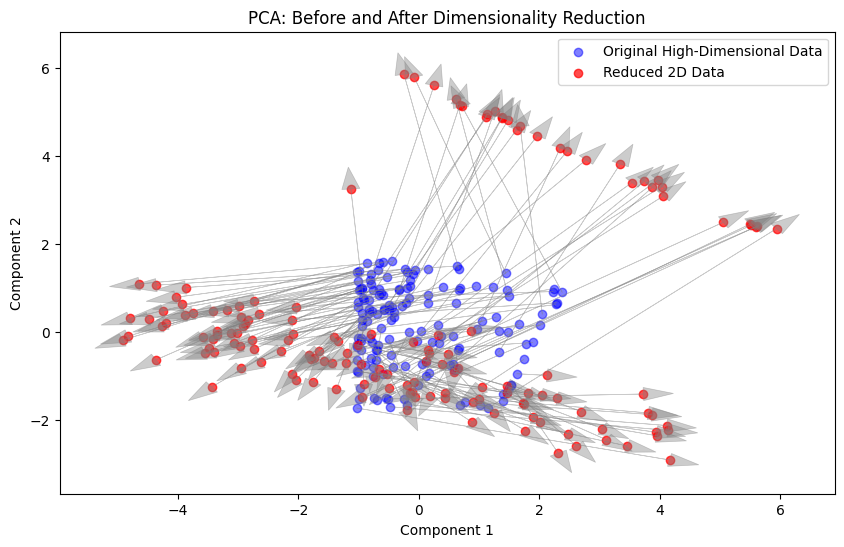

In [ ]:
# %%

# Visualize Before and After for PCA
plot_before_after(er_before_hospitalization2_scaled.values[:, :2], er_pca, "PCA: Before and After Dimensionality Reduction", sample_size=150)

# PCA (Principal Component Analysis)

### Observations:
- PCA is a linear dimensionality reduction method that focuses on preserving the global variance of the dataset.

### Strengths:
- **Global variance preservation**: PCA captures the major directions in which the data varies, making it suitable for datasets with linear relationships.
- **Computational efficiency**: PCA is one of the fastest dimensionality reduction methods and can handle large datasets efficiently.
- **Interpretability**: The output is easy to understand, as each principal component represents a direction of maximal variance.

### Weaknesses:
- **Poor handling of non-linear structures**: PCA cannot capture non-linear relationships between features.
- **Local distortions**: Neighboring relationships can become distorted, especially if the data has a complex, non-linear structure.

### Best Used For:
- When you want to understand the global structure or variance in the data and have datasets with linear relationships.
- Large datasets where computational efficiency is important.

### Conclusion about PCA:
- In the **Original High-Dimensional Neighbors** plot, the structure is compact and well-connected.
- In the **Reduced Low-Dimensional Neighbors** plot, PCA maintains some of the neighboring relationships, but the data appears stretched linearly.
- PCA captures global relationships effectively, but the transformation tends to distort local structures, as it cannot handle non-linear relationships.

PCA performed well for this data, as indicated by the explained variance and clear cluster separation in the plots. PCA preserves the linear structure and is highly interpretable.


In [ ]:
# %%

# ### t-SNE Analysis ###
# t-SNE is a non-linear dimensionality reduction method primarily used for visualization. It preserves local structures and relationships but might not maintain global separation as well.
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
er_tsne = tsne.fit_transform(er_before_hospitalization2_scaled)

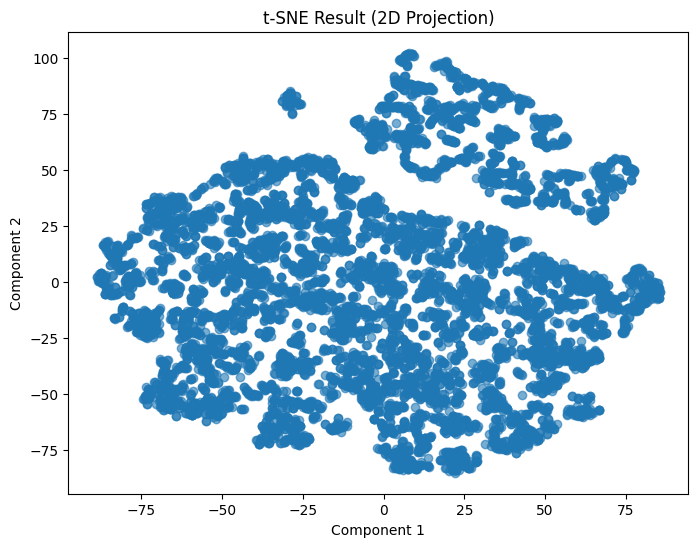

In [ ]:
# %%

# Plot t-SNE Results
plt.figure(figsize=(8,6))
plt.scatter(er_tsne[:, 0], er_tsne[:, 1], alpha=0.6)
plt.title('t-SNE Result (2D Projection)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

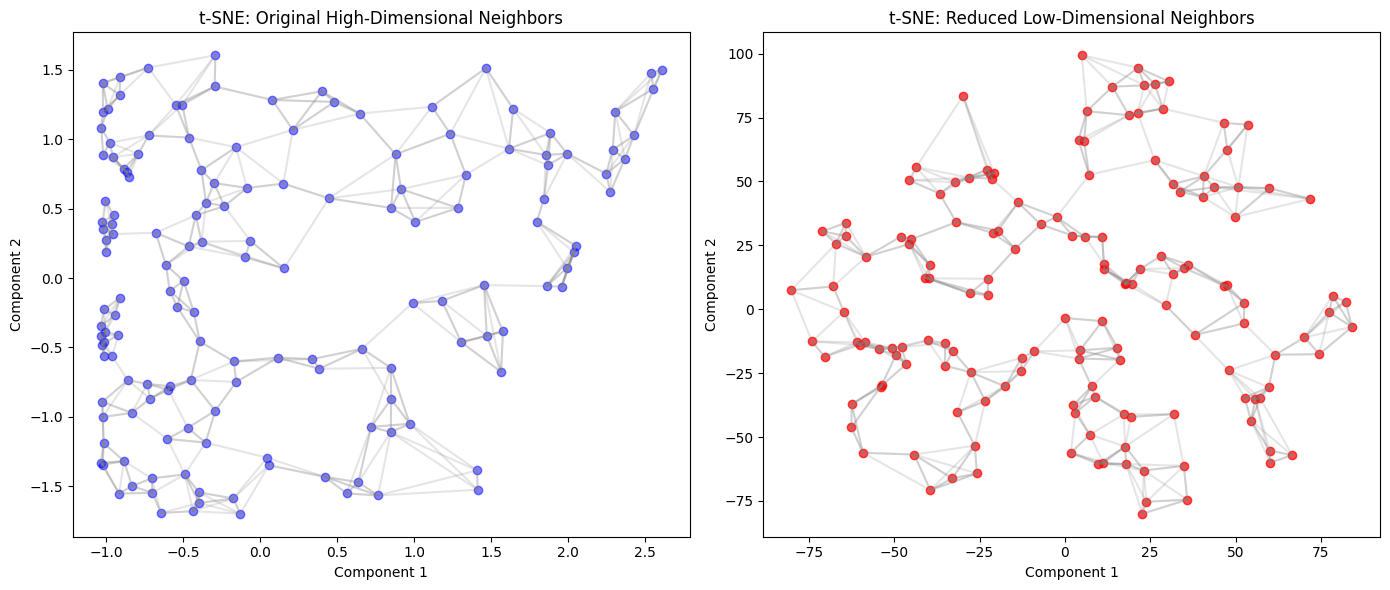

In [ ]:
# %% 

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
er_tsne = tsne.fit_transform(er_before_hospitalization2_scaled)

# Visualize neighborhood relationships for t-SNE
plot_neighbors_before_after(er_before_hospitalization2_scaled.values[:, :2], er_tsne, "t-SNE", sample_size=150, n_neighbors=5)

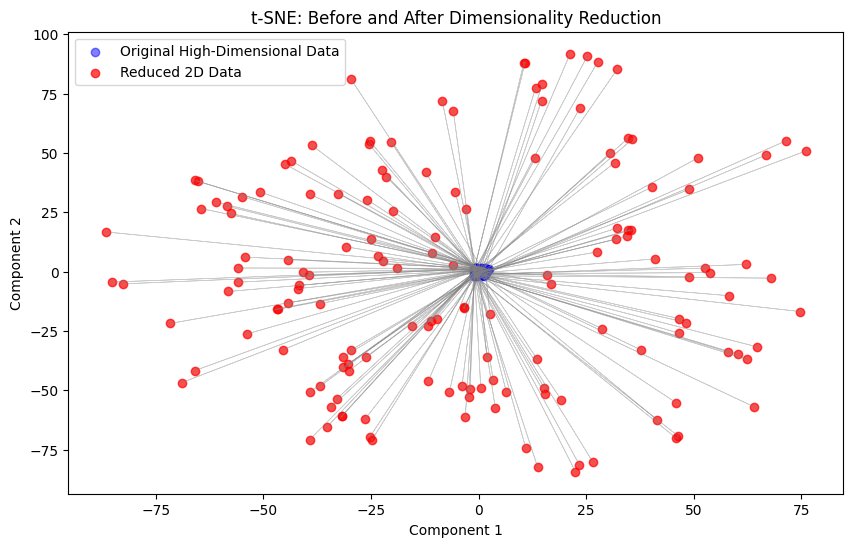

In [ ]:
# %%

# Visualize Before and After for t-SNE
plot_before_after(er_before_hospitalization2_scaled.values[:, :2], er_tsne, "t-SNE: Before and After Dimensionality Reduction", sample_size=150)

# t-SNE (t-Distributed Stochastic Neighbor Embedding)

### Observations:
- t-SNE is a non-linear method that focuses on preserving local relationships and small clusters within the data.

### Strengths:
- **Captures local structure**: t-SNE is excellent at preserving neighboring relationships, making it ideal for visualizing clusters.
- **Reveals hidden patterns**: t-SNE uncovers detailed structures that other methods may miss, especially for non-linear datasets.

### Weaknesses:
- **Global structure distortion**: t-SNE often fails to preserve the larger structure, leading to distorted relationships between clusters.
- **Computationally expensive**: t-SNE is slow to compute, especially on larger datasets, which limits its scalability.

### Best Used For:
- When you need to visualize local clusters in high-dimensional data, particularly when the data has non-linear relationships.
- Suitable for small datasets or when the goal is to uncover fine-grained local structures.

### Conclusion about t-SNE:
- In the **left plot** (Original High-Dimensional Neighbors), there are tightly connected neighborhoods.
- In the **right plot** (Reduced Low-Dimensional Neighbors), t-SNE does a great job of preserving local clusters and neighbor relationships. However, the global structure appears distorted, which is typical for t-SNE.

t-SNE captured local structures well but had a lower Silhouette Score (0.404). It may not have preserved global separation between clusters as well as PCA, making it ideal for detailed visualizations of smaller clusters.


In [ ]:
# %%

# ### UMAP Analysis ###
# UMAP is a non-linear method designed to balance local and global structure preservation, making it scalable and useful for visualization and cluster separation.
# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
er_umap = umap_model.fit_transform(er_before_hospitalization2_scaled)

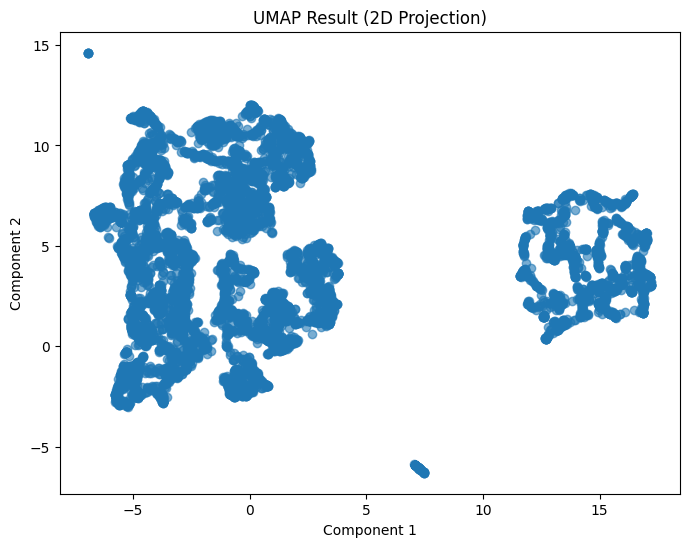

In [ ]:
# %%

# Plot UMAP Results
plt.figure(figsize=(8,6))
plt.scatter(er_umap[:, 0], er_umap[:, 1], alpha=0.6)
plt.title('UMAP Result (2D Projection)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

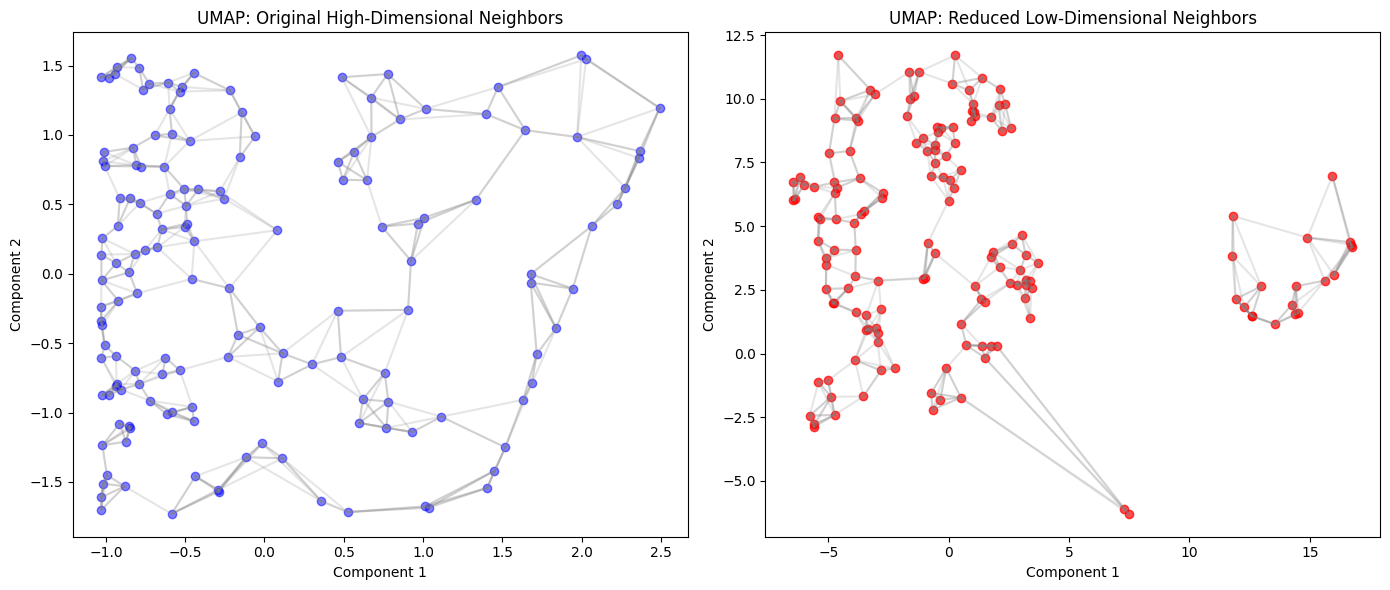

In [ ]:
# %% 

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
er_umap = umap_model.fit_transform(er_before_hospitalization2_scaled)

# Visualize neighborhood relationships for UMAP
plot_neighbors_before_after(er_before_hospitalization2_scaled.values[:, :2], er_umap, "UMAP", sample_size=150, n_neighbors=5)

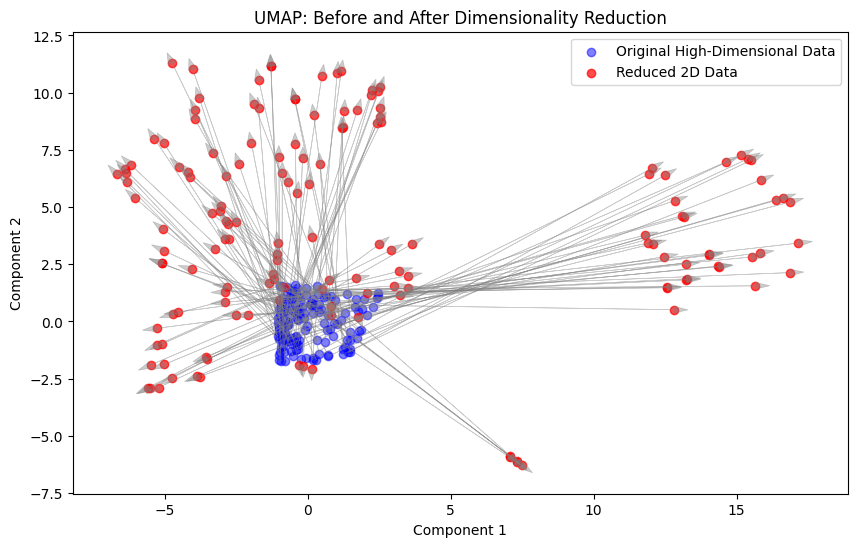

In [ ]:
# %%

# Visualize Before and After for UMAP
plot_before_after(er_before_hospitalization2_scaled.values[:, :2], er_umap, "UMAP: Before and After Dimensionality Reduction", sample_size=150)

# UMAP (Uniform Manifold Approximation and Projection)

### Observations:
- UMAP is a non-linear method designed to balance both local and global structure preservation. It is faster and more scalable than t-SNE.

### Strengths:
- **Balances local and global structures**: UMAP is effective at preserving both small, local relationships and larger, global structures within the data.
- **Scalability**: UMAP is faster and more computationally efficient than t-SNE, making it suitable for large datasets.
- **Cluster separation**: UMAP often produces clearer cluster separation compared to t-SNE.

### Weaknesses:
- **Parameter sensitivity**: UMAP's performance can depend on its parameters (e.g., number of neighbors), which may require careful tuning.
- **Potential loss of global structure**: Although UMAP balances local and global preservation better than t-SNE, it can still lose some global structure in highly complex datasets.

### Best Used For:
- When you need to preserve both local and global structures in a dataset.
- Suitable for large datasets, where t-SNE would be computationally expensive.
- Useful for tasks that require good cluster separation and scalability.

### Conclusion about UMAP:
- In the **left plot** (Original High-Dimensional Neighbors), the local and global structures of the original data are clearly visible and well-connected.
- In the **right plot** (Reduced Low-Dimensional Neighbors), UMAP preserves local clusters while also maintaining a decent global structure, with clusters being moderately well-separated.

UMAP produced a moderate Silhouette Score (0.511), indicating a good balance between local and global structure preservation. UMAP is scalable and works well on larger datasets, and its ability to capture both local and global structures makes it useful for clustering tasks.


In [ ]:
# %%

# Apply SVD
# SVD (Singular Value Decomposition) is a linear dimensionality reduction method similar to PCA.
# It reduces the data based on variance and is often used in large matrix factorization problems.

# Apply SVD to the data
svd_model = TruncatedSVD(n_components=2, random_state=42)
er_svd = svd_model.fit_transform(er_before_hospitalization2_scaled)

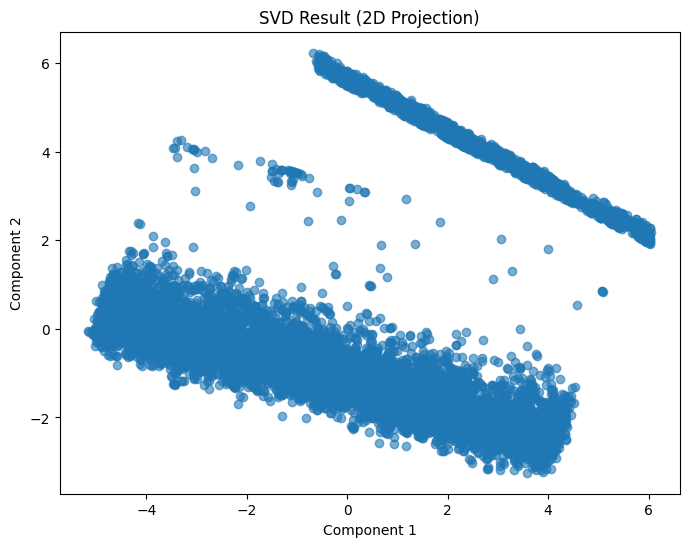

In [ ]:
# %%

# Plot SVD Results
plt.figure(figsize=(8,6))
plt.scatter(er_svd[:, 0], er_svd[:, 1], alpha=0.6)
plt.title('SVD Result (2D Projection)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

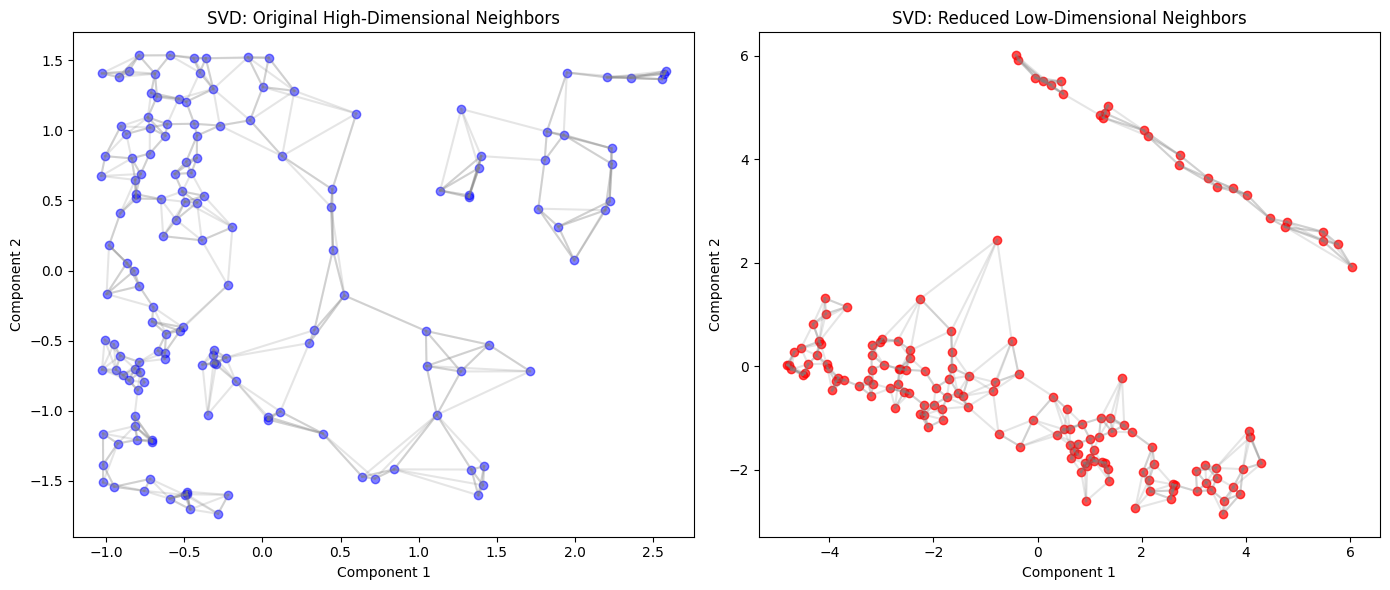

In [ ]:
# %% 

# Visualize neighborhood relationships for SVD
plot_neighbors_before_after(er_before_hospitalization2_scaled.values[:, :2], er_svd, "SVD", sample_size=150, n_neighbors=5)

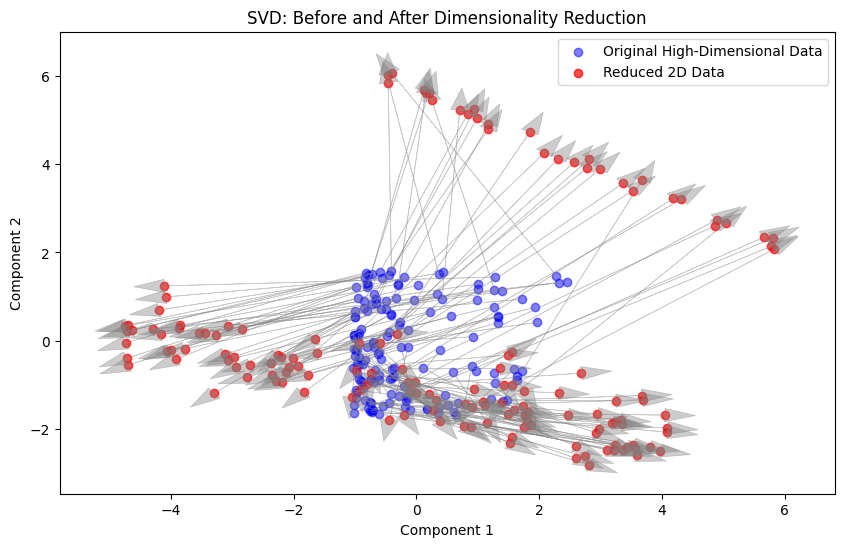

In [ ]:
# %%

# Visualize Before and After for SVD
plot_before_after(er_before_hospitalization2_scaled.values[:, :2], er_svd, "SVD: Before and After Dimensionality Reduction", sample_size=150)

# SVD (Singular Value Decomposition)

### Observations:
- SVD is a linear method like PCA, used to decompose data into its principal components.
- SVD, like PCA, is good at capturing global variance but struggles to handle complex non-linear relationships.

### Strengths:
- **Global structure preservation**: SVD excels in preserving large-scale relationships between features.
- **Efficient and scalable**: Similar to PCA, SVD is computationally efficient and suitable for large-scale data processing.
- **Good for matrix factorization**: SVD is often used for tasks such as text analysis (e.g., Latent Semantic Analysis) and image compression.

### Weaknesses:
- **Local structure distortion**: Like PCA, SVD struggles to capture non-linear relationships, leading to distorted local clusters.
- **Linear method**: SVD does not work well with non-linear structures.

### Best Used For:
- When working with linear datasets or applications such as text processing, image analysis, or matrix factorization.
- Best for global structure preservation and when computational efficiency is key.

### Conclusion about SVD:
- In the **Original High-Dimensional Neighbors** plot, SVD captures the global structure and maintains connectivity between data points.
- In the **Reduced Low-Dimensional Neighbors** plot, SVD produces a linear projection similar to PCA, but local clusters may not be preserved as well.

SVD produced the same Silhouette Score as PCA (0.589), indicating that it performs similarly in terms of clustering and global structure preservation. However, SVD may be preferred in scenarios involving matrix factorization or when dealing with tasks like text analysis or image compression, where computational efficiency and global variance are crucial.


#  Clustering Evaluation using Silhouette Score ###

The **Silhouette Score** is a metric used to evaluate how well the data points are grouped into clusters after applying dimensionality reduction and clustering algorithms, such as KMeans.

### What does the Silhouette Score measure?
- **Silhouette Score** measures the **compactness** of clusters and how **distinct** each cluster is from others.
- It calculates how similar a data point is to its own cluster compared to other clusters. This is done by computing the **mean intra-cluster distance** (the average distance between a point and other points in the same cluster) and the **mean nearest-cluster distance** (the average distance from the point to points in the nearest different cluster).
- The score ranges from **-1** to **1**:
  - **1** indicates that data points are well-clustered, with clear separations between clusters.
  - **0** means that data points are on or very close to the decision boundary between clusters.
  - **-1** suggests that data points might have been assigned to the wrong cluster, as they are closer to a neighboring cluster than their own.

### How to interpret the Silhouette Score?
- A **higher Silhouette Score** indicates better clustering, meaning the data points within a cluster are closer to each other (higher cohesion), and the clusters themselves are well-separated (higher separation).
- A **lower score** indicates poor clustering, where the boundaries between clusters are less distinct, and data points may be close to points in other clusters.

### Silhouette Score and Dimensionality Reduction:
- After applying **dimensionality reduction** methods such as **PCA**, **t-SNE**, **UMAP**, or **SVD**, the Silhouette Score helps evaluate how well the clusters in the lower-dimensional space are separated.
- Dimensionality reduction methods aim to project the data into fewer dimensions while retaining as much meaningful structure as possible. A high Silhouette Score after dimensionality reduction suggests that the method preserved the clusters well.

### Why is the Silhouette Score important?
- It provides a **quantitative measure** to compare the quality of clustering before and after dimensionality reduction.
- It helps in **selecting the best dimensionality reduction method** by allowing you to compare how different methods affect the cluster separation and structure.
- In many cases, clustering results in high-dimensional space may degrade when reduced to 2D or 3D. The Silhouette Score helps identify when a method has done well in retaining this structure.

### Key Points to Remember:
- **Score ranges** from **-1 to 1** with **1** being the best possible score, indicating **well-separated clusters**.
- **Scores closer to 1** suggest strong separation between clusters and compact groupings of data points.
- **Scores closer to 0** indicate that the clusters overlap or are not well-defined.
- **Negative scores** imply that some points are likely **misclassified** and belong to neighboring clusters.

### Application in Dimensionality Reduction Methods:
When using **PCA**, **t-SNE**, **UMAP**, or **SVD**, the Silhouette Score is crucial in assessing the quality of clusters in the reduced space:
- **PCA**: Often has a higher Silhouette Score if the data has linear separability.
- **t-SNE**: Works well for preserving local structures but may have a lower Silhouette Score if the global structure is distorted.
- **UMAP**: Balances both local and global structures, leading to moderate to high Silhouette Scores.
- **SVD**: Performs similarly to PCA, with higher scores if the data is linearly separable.

In summary, a higher Silhouette Score after applying dimensionality reduction indicates that the method successfully preserved the structure of the clusters, making it a valuable tool for choosing the best technique for your data.


In [ ]:
# Apply KMeans for clustering and evaluate using Silhouette Score
kmeans = KMeans(n_clusters=3, random_state=42)

In [ ]:
# %%

# Silhouette Score for PCA
labels_pca = kmeans.fit_predict(er_pca)
silhouette_pca = silhouette_score(er_pca, labels_pca)
print(f"Silhouette Score for PCA: {silhouette_pca:.5f}")

Silhouette Score for PCA: 0.58893


In [ ]:
# %%

# Silhouette Score for t-SNE
labels_tsne = kmeans.fit_predict(er_tsne)
silhouette_tsne = silhouette_score(er_tsne, labels_tsne)
print(f"Silhouette Score for t-SNE: {silhouette_tsne:.5f}")

Silhouette Score for t-SNE: 0.40438


In [ ]:
# %%

# Silhouette Score for UMAP
labels_umap = kmeans.fit_predict(er_umap)
silhouette_umap = silhouette_score(er_umap, labels_umap)
print(f"Silhouette Score for UMAP: {silhouette_umap:.5f}")

Silhouette Score for UMAP: 0.51055


In [ ]:
# %%

# Silhouette Score for SVD
labels_svd = kmeans.fit_predict(er_svd)
silhouette_svd = silhouette_score(er_svd, labels_svd)
print(f"Silhouette Score for SVD: {silhouette_svd:.5f}")

Silhouette Score for SVD: 0.58893


# Summary of the Comparison:

| **Method** | **Strengths** | **Weaknesses** | **Best Used For** |
|------------|----------------|----------------|-------------------|
| **PCA** | - Preserves global variance well. <br> - Computationally efficient. <br> - Easy to interpret. | - Fails to preserve local non-linear relationships. <br> - Not suitable for non-linear structures. | Understanding the global structure or variance in the data and for linear relationships. |
| **t-SNE** | - Excellent at capturing local structures. <br> - Reveals hidden clusters and patterns. | - Poor at preserving global structure. <br> - Computationally expensive and does not scale well to large datasets. | Best for visualizing local clusters and revealing non-linear relationships, especially for small datasets. |
| **UMAP** | - Balances local and global structures well. <br> - Faster and more scalable than t-SNE. <br> - Good for cluster separation while preserving global structure. | - Some global structure might still be lost. <br> - Requires parameter tuning for optimal performance. | Ideal when you need a balance between local structure preservation and global relationships, especially for large datasets. |
| **SVD** | - Global structure preservation. <br> - Efficient and scalable. <br> - Useful for matrix factorization tasks. | - Poor at preserving non-linear relationships. <br> - Local clusters might be distorted. | Useful for linear datasets and tasks like text analysis or image processing. |

---

### Final Recommendation on Dimensionality Reduction Method:

- **If global structure is important**: PCA or SVD is the better choice, as they focus on preserving overall variance and give a clearer picture of large-scale relationships.
- **If local relationships are critical**: t-SNE is ideal for capturing small clusters and local structures but may distort global relationships.
- **If you need a balance**: UMAP is the best compromise, as it preserves both local clusters and some global structures, while being faster and more scalable than t-SNE.

---

### Silhouette Scores:
- **PCA**: 0.58893
- **t-SNE**: 0.40438
- **UMAP**: 0.51055
- **SVD**: 0.58893

---

### Based on the Silhouette Scores:

- **PCA** and **SVD** are best for capturing **global structures**, providing the best clustering performance.
- **UMAP** offers a **balance between local preservation and global structure**, performing better than t-SNE but slightly less effective than PCA and SVD.
- **t-SNE** is better suited for **visualizing fine-grained local clusters**, but its distortion of global relationships results in a lower Silhouette Score.
